### Dogs of Zurich - Stats Analysis

All the data was taken from Open Data Zurich (https://data.stadt-zuerich.ch/dataset/pd-stapo-hundebestand) which was made avaiable through Kaggle by user 'K Scott Mader' (Link - https://www.kaggle.com/datasets/kmader/dogs-of-zurich)

##### Data load and cleaning steps

In [ ]:
#Installs kagglehub for dataset - uncomment if needed
#!pip install kagglehub
#!pip install prophet
#!pip install xgboost

# Imports libraries
import os
import requests
import json
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from datetime import datetime
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error

In [ ]:
# Download latest version
path = kagglehub.dataset_download("kmader/dogs-of-zurich")

# List Path & files 
print("Dataset downloaded to:", path)
print("Files:", os.listdir(path))

Dataset downloaded to: C:\Users\Devin Ferko\.cache\kagglehub\datasets\kmader\dogs-of-zurich\versions\2
Files: ['20151001hundehalter.csv', '20160307hundehalter.csv', '20170308hundehalter.csv', 'zuordnungstabellehunderassehundetyp.csv']


In [ ]:
# Load the 3 needed csv files
csv1 = os.path.join(path, "20151001hundehalter.csv")
csv2 = os.path.join(path, "20160307hundehalter.csv")
csv3 = os.path.join(path, "20170308hundehalter.csv")
df1 = pd.read_csv(csv1)
df2 = pd.read_csv(csv2)
df3 = pd.read_csv(csv3)

# Add date columns to each dataframe (matches what is in the csv title)
df1['date'] = pd.to_datetime('2015-10-01')
df2['date'] = pd.to_datetime('2016-03-07')
df3['date'] = pd.to_datetime('2017-03-08')

#print(df1.head(), df2.head(), df3.head())

In [ ]:
# Concat rows

df = pd.concat([df1, df2, df3], ignore_index=True)

#confirm
print(df.shape)
#print(df.head())
#print(df.tail())

(21065, 14)


In [ ]:
# Since the raw data is in german, we will rename the columns to english
df.rename(columns={
    'HALTER_ID': 'owner_id',
    'ALTER': 'age',
    'GESCHLECHT': 'gender',
    'STADTKREIS': 'city_district',
    'STADTQUARTIER': 'city_quarter',
    'RASSE1': 'breed_1',
    'RASSE1_MISCHLING': 'breed_1_mixed',
    'RASSE2': 'breed_2',
    'RASSE2_MISCHLING': 'breed_2_mixed',
    'RASSENTYP': 'breed_type',
    'GEBURTSJAHR_HUND': 'dog_birth_year',
    'GESCHLECHT_HUND': 'dog_gender',
    'HUNDEFARBE': 'dog_color'
}, inplace=True)

# Change Gender to male or female
df['gender'] = df['gender'].map({'m': 'male', 'w': 'female'})

#Confirms
print(df.head())

   owner_id    age  gender  city_district  city_quarter             breed_1  \
0       126  51-60    male            9.0          92.0       Welsh Terrier   
1       574  61-70  female            2.0          23.0       Cairn Terrier   
2       695  41-50    male            6.0          63.0  Labrador Retriever   
3       893  61-70  female            7.0          71.0     Mittelschnauzer   
4      1177  51-60    male           10.0         102.0            Shih Tzu   

  breed_1_mixed breed_2  breed_2_mixed breed_type  dog_birth_year dog_gender  \
0           NaN     NaN            NaN          K            2011          w   
1           NaN     NaN            NaN          K            2002          w   
2           NaN     NaN            NaN          I            2012          w   
3           NaN     NaN            NaN          I            2010          w   
4           NaN     NaN            NaN          K            2011          m   

       dog_color       date  
0  schwarz/bra

In [ ]:
# Check for missing values
df.isna().sum()

owner_id              0
age                   5
gender                0
city_district         5
city_quarter          5
breed_1               0
breed_1_mixed     19126
breed_2           19475
breed_2_mixed     21065
breed_type          174
dog_birth_year        0
dog_gender            0
dog_color             0
date                  0
dtype: int64

In [ ]:
# Remove cols with too many missing values
df.drop(columns=['breed_1_mixed','breed_2', 'breed_2_mixed'], inplace=True)

# Drop year values that are not realistic
df.drop(df[(df['dog_birth_year'] < 1990) | (df['dog_birth_year'] > 2020)].index, inplace=True)

In [ ]:
# Remove duplicates if any
df.drop_duplicates(inplace=True)
print("Data shape after removing duplicates:", df.shape)

Data shape after removing duplicates: (20965, 11)


##### Features exploration

age
11-20      127
21-30     2332
31-40     3922
41-50     4454
51-60     4532
61-70     3077
71-80     1945
81-90      524
91-100      47
Name: count, dtype: int64


<Axes: title={'center': 'Number of Dog Owners by Age'}, xlabel='age'>

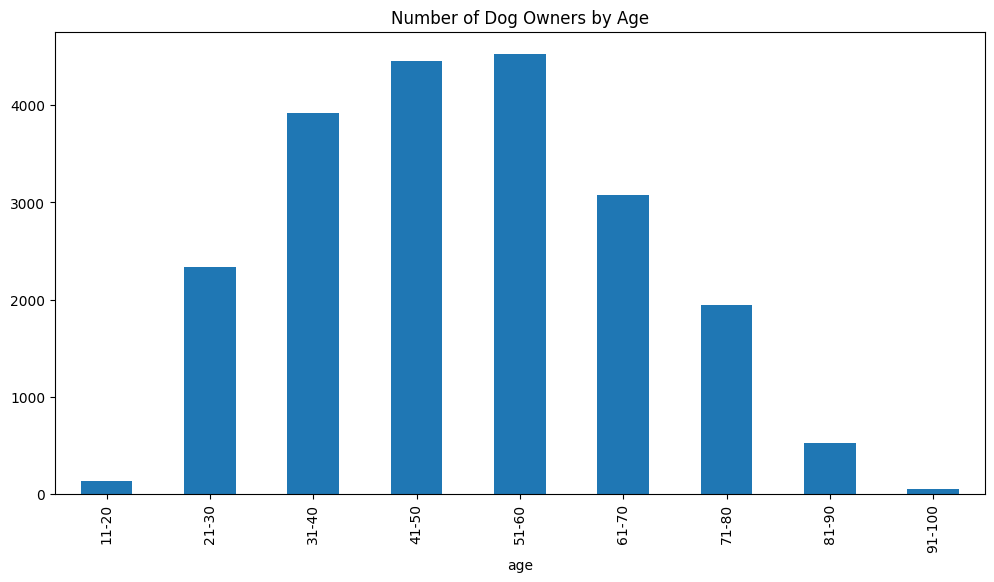

In [ ]:
# Plot owners by age
owners_by_age = df['age'].value_counts().sort_index()
print(owners_by_age) 
owners_by_age.plot(kind='bar', figsize=(12, 6), title='Number of Dog Owners by Age') 

gender
female    14436
male       6529
Name: count, dtype: int64


<Axes: title={'center': 'Number of Dog Owners by Gender'}, xlabel='gender'>

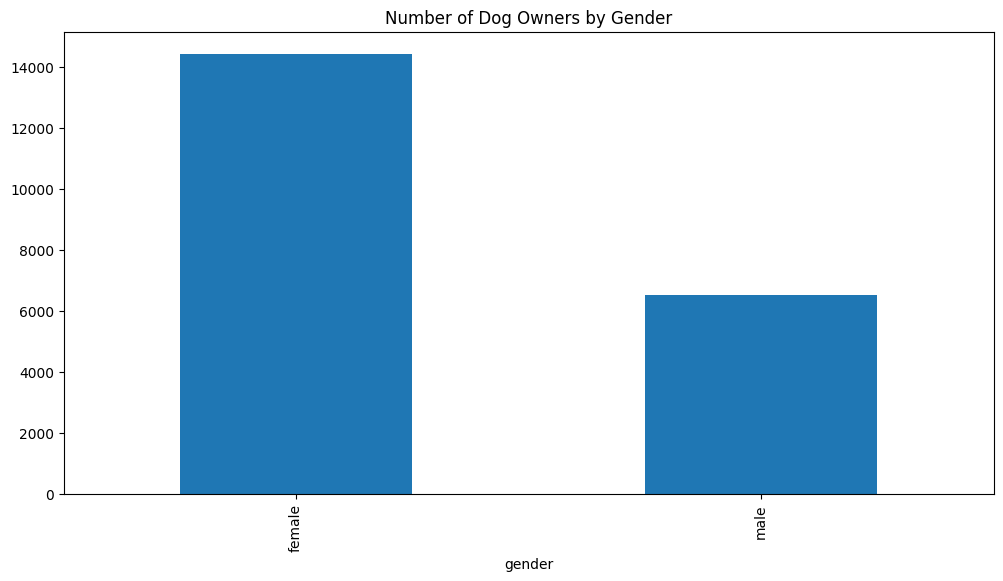

In [ ]:
# Plot owners by gender
owners_by_gender = df['gender'].value_counts().sort_index()
print(owners_by_gender) 
owners_by_gender.plot(kind='bar', figsize=(12, 6), title='Number of Dog Owners by Gender') 

Text(0, 0.5, 'Count')

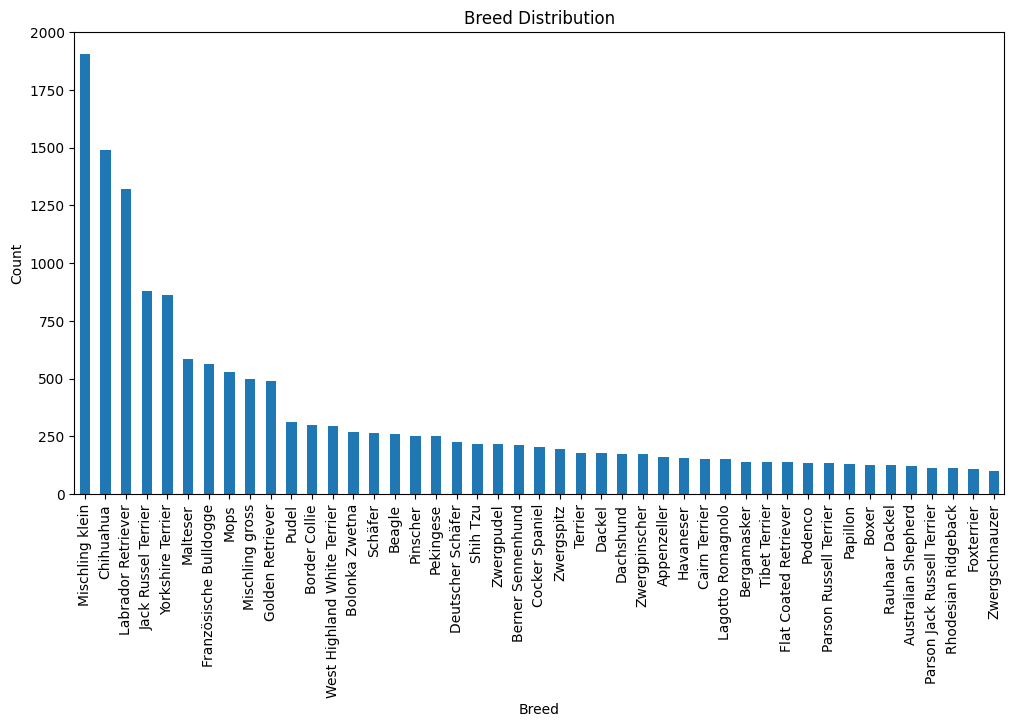

In [ ]:
# Breed of dogs
ax = df['breed_1'].value_counts().head(45).plot(kind='bar', title='Breed Distribution', figsize=(12, 6))
ax.set_xlabel('Breed')
ax.set_ylabel('Count')

dog_birth_year
1994       2
1995       1
1996       3
1997      16
1998      65
1999     111
2000     251
2001     399
2002     661
2003     834
2004    1176
2005    1245
2006    1317
2007    1468
2008    1513
2009    1651
2010    1698
2011    1636
2012    1867
2013    1724
2014    1687
2015    1129
2016     510
2017       1
Name: count, dtype: int64


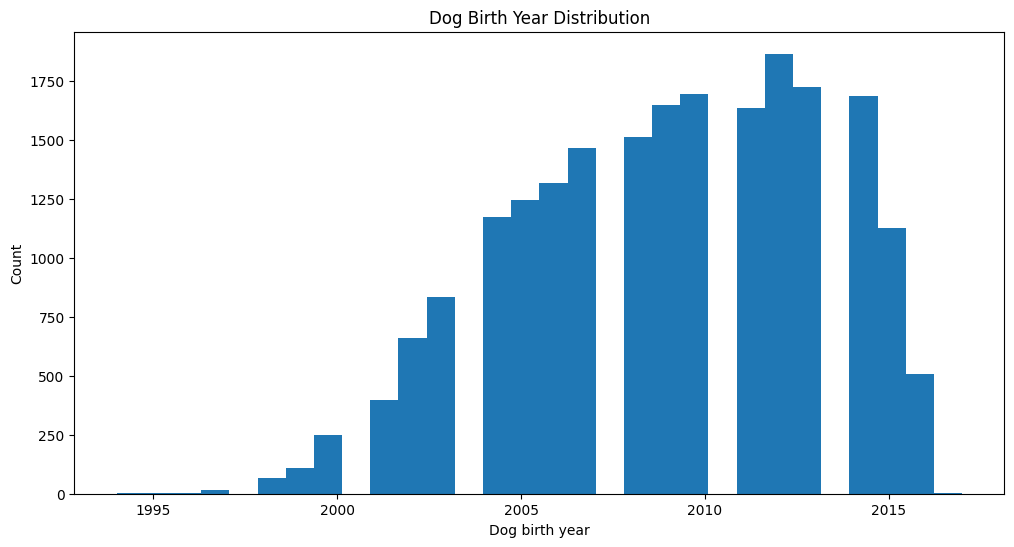

In [ ]:
# Dog birth year
ax = df['dog_birth_year'].plot(kind='hist', bins=30,title='Dog Birth Year Distribution', figsize=(12, 6))
ax.set_xlabel('Dog birth year')
ax.set_ylabel('Count')

dog_birth_year = df['dog_birth_year'].value_counts().sort_index()
print(dog_birth_year)

### Notes
- Most dog owners are female
- The most popular breed is mischling klein or small mixed breen (eng)
- 2007-2014 makes up the bulk of birth years for dogs, with few dogs being born on or before 2000